In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
import tensorflow as tf

In [ ]:
%cd /content/drive/MyDrive/mosaic/
root = "/content/drive/MyDrive/mosaic/"

/content/drive/MyDrive/mosaic


In [ ]:
img1 = cv2.imread(root + 'test_images/test1.jpg')
img2 = cv2.imread(root + 'test_images/test2.jpg')
img3 = cv2.imread(root + 'test_images/test3.jpg')
img4 = cv2.imread(root + 'test_images/test4.jpg')
img5 = cv2.imread(root + 'test_images/test5.jpg')
img6 = cv2.imread(root + 'test_images/test6.jpg')
img7 = cv2.imread(root + 'test_images/test7.jpg')
img8 = cv2.imread(root + 'test_images/test8.jpeg')
img9 = cv2.imread(root + 'test_images/test9.jpeg')

In [ ]:
def preprocess_img(img, thresh=1):
  # blur
  new_img = cv2.GaussianBlur(img, (3,3),0)

  # shadow removal
  rgb_planes = cv2.split(new_img)
  result_norm_planes = []    
  clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
  for plane in rgb_planes:
    dilated_img = cv2.dilate(plane,np.ones((7,7),np.uint8))
    bg_img = cv2.medianBlur(dilated_img, 21)
    diff_img = 255 - cv2.absdiff(plane,bg_img)
    norm_img = cv2.normalize(diff_img,None,alpha=0,beta=255,norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_8UC1)
    norm_img = clahe.apply(norm_img)
    result_norm_planes.append(norm_img)
  new_img = cv2.merge(result_norm_planes)
  new_img = cv2.cvtColor(new_img,cv2.COLOR_BGR2GRAY)

  # binarization
  __,new_img = cv2.threshold(new_img,170,255,cv2.THRESH_BINARY_INV)
  kernel = np.ones((3,3),np.uint8)
  new_img = cv2.dilate(new_img,kernel,iterations=2)
  new_img = cv2.erode(new_img,kernel,iterations=1)

  # dot removal
  nlabels, labels, stats, centroids = cv2.connectedComponentsWithStats(new_img, None, None, None, 8, cv2.CV_32S)
  areas = stats[1:,cv2.CC_STAT_AREA]
  result = np.zeros((labels.shape), np.uint8)
  for i in range(0, nlabels - 1):
      if areas[i]/np.sum(areas) >= thresh/100:
          result[labels == i + 1] = 255
  return result

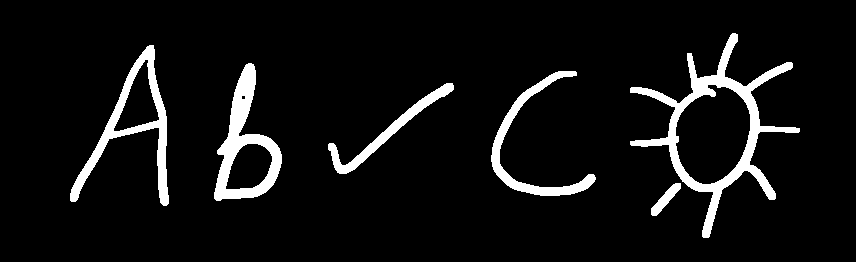

In [ ]:
cv2_imshow(preprocess_img(img9))

In [ ]:
img1 = preprocess_img(img1)
img2 = preprocess_img(img2)
img3 = preprocess_img(img3)
img4 = preprocess_img(img4)
img5 = preprocess_img(img5)
img6 = preprocess_img(img6)
img7 = preprocess_img(img7)
img8 = preprocess_img(img8)
img9 = preprocess_img(img9)

In [ ]:
def crop_captcha(test, thresh=0.1):
  u = np.where((np.sum(test, axis=1)/np.sum(test))>thresh/100)[0].min()
  d = np.where((np.sum(test, axis=1)/np.sum(test))>thresh/100)[0].max()
  l = np.where((np.sum(test, axis=0)/np.sum(test))>thresh/100)[0].min()
  r = np.where((np.sum(test, axis=0)/np.sum(test))>thresh/100)[0].max()
  return test[u:d,l:r]

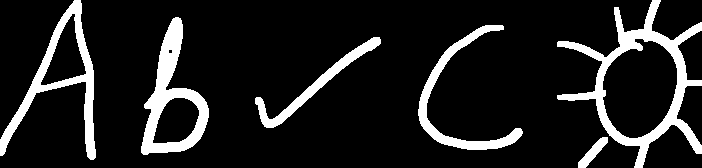

In [ ]:
cv2_imshow(crop_captcha(img9))

In [ ]:
img1 = crop_captcha(img1)
img2 = crop_captcha(img2)
img3 = crop_captcha(img3)
img4 = crop_captcha(img4)
img5 = crop_captcha(img5)
img6 = crop_captcha(img6)
img7 = crop_captcha(img7)
img8 = crop_captcha(img8)
img9 = crop_captcha(img9)

In [ ]:
def segment(img, thresh1=0.001, thresh2=1.2):
  test = img.copy()
  arr = np.where((np.sum(test, axis=0)/np.sum(test)) < thresh1/100)[0]
  i = 0
  l,r = list(), list()
  while(i<len(arr)):
    l.append(arr[i])
    i+=1
    while(i<(len(arr)-1) and arr[i+1]==arr[i]+1):
      i+=1
    r.append(arr[i])
    i+=1
  i = 0
  while(i<len(l)-1):
    if ((l[i+1]-r[i])/test.shape[1]) < thresh2/100:
      l.pop(i+1)
      r.pop(i)
    else:
      i+=1
  ret = list()
  prev = 0
  for i in range(len(l)):
    x = (l[i]+r[i])//2
    ret.append(test[:, prev:x])
    prev = x
  ret.append(test[:, prev:])
  return ret

In [ ]:
def add_border(img, shape):
  if img.shape[0] > img.shape[1]:
    x = (img.shape[0]-img.shape[1])
    y = x//2
    img = cv2.copyMakeBorder(
        img,
        top = 10,
        bottom = 10,
        left = y+10,
        right = x-y+10,
        borderType = cv2.BORDER_CONSTANT,
        value = 0 
    )
  else:
    x = (img.shape[1]-img.shape[0])
    y = x//2
    img = cv2.copyMakeBorder(
        img,
        top = y+10,
        bottom = x-y+10,
        left = 10,
        right = 10,
        borderType = cv2.BORDER_CONSTANT,
        value = 0 
    )
  img = cv2.resize(img, (shape,shape), interpolation=cv2.INTER_CUBIC)#
  return img

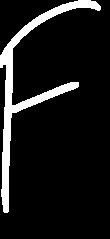

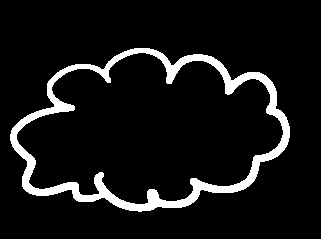

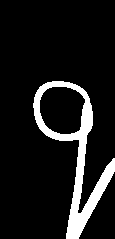

In [ ]:
img_list = list()
for img in segment(img8,thresh2=3):
  img_list.append(img)
  cv2_imshow(img)
  print('\n')

In [ ]:
def morph(img, ker1=3,ker2=7,it1=1,it2=3):
  img = cv2.dilate(img, np.ones((ker1,ker1),np.uint8), it1)
  img = cv2.erode(img, np.ones((ker2,ker2), np.uint8), it2)
  return img

In [ ]:
def centre_img(test):
  M = cv2.moments(test, binaryImage=True)
  if M["m00"] != 0:
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
  else:
    cX, cY = 0, 0
  height, width = test.shape[:2]
  translation_matrix = np.array([
    [1, 0, width//2-cX],
    [0, 1, height//2-cY],
  ], dtype=np.float32)
  translated_image = cv2.warpAffine(src=test, M = translation_matrix, dsize=(width, height))
  return translated_image

In [ ]:
model = tf.keras.models.load_model(root+'emoji_model')

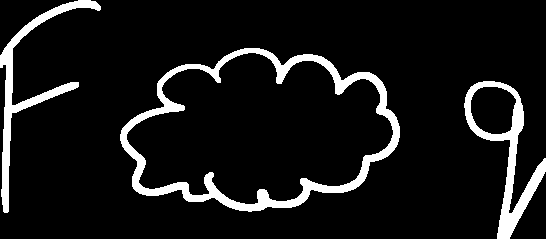

In [ ]:
cv2_imshow(img8)

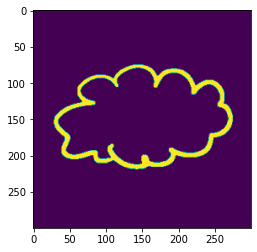

In [ ]:
test = (add_border(segment(img9, thresh2=3)[1], 300))
test = centre_img(test)
plt.imshow(test)
test = np.expand_dims(test.astype(np.float32)/255, [-1,0])

In [ ]:
pred = model.predict(test)
pred

array([[0.15280452, 0.14552926, 0.13814287, 0.14370745, 0.1360042 ,
        0.14297928, 0.14083241]], dtype=float32)

In [ ]:
np.argmax(pred)

3